# Custom Callbacks

* **ModelCheckpoint callback:** can be used to automatically save a model after each epoch, or just the best one.
* **TensorBoard callback:** allows us to monitor the training process in realtime with TensorBoard.
* **EarlyStopping callback:** ensures that the training process stops if the loss value does no longer improve.
* **LearningRateScheduler callback:** updates the learning rate before the start of an epoch, based on a scheduler function.
* **ReduceLROnPlateau callback:** reduces learning rate if the loss value does no longer improve.
* **RemoteMonitor callback:** sends TensorFlow training events to a remote monitor, such as a logging system.
* **LambdaCallback:** allows us to define simple functions that can be executed as a callback.
* **TerminateOnNaN callback:** if the loss value is Not a Number (NaN), the training process stops.
* **CSVLogger callback:** streams the outcome of an epoch to a CSV file.
* **ProgbarLogger callback: used to determine what is printed to standard output in the Keras progress bar.* 

In [2]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.datasets import mnist
from sklearn.model_selection import train_test_split
import tensorflow as tf 

import matplotlib.pyplot as plt 
import numpy as np
import io
import imageio
from PIL import Image
from IPython.display import Image as IPyImage


# Download Mnist Dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train.reshape(60000, 784).astype('float32') / 255, x_test.reshape(10000, 784).astype('float32') / 255

In [5]:
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.losses import SparseCategoricalCrossentropy

def get_model():
    ''' 
    Building simple model
    '''
    model = Sequential()
    model.add(Input(shape = (784,)))
    model.add(Dense(units = 32, activation = 'linear'))
    model.add(Dense(units = 10, activation = 'softmax'))
    model.compile(optimizer = RMSprop(learning_rate =1e-4), 
                  loss = SparseCategoricalCrossentropy(), 
                  metrics=['accuracy'])
    return model

## Callbacks from Keras API 

In [6]:
import math

# Stop training when a monitored metric has stopped improving.
early_stopping = EarlyStopping(monitor = 'val_loss',
                               patience = 3,
                               restore_best_weights = True,
                               mode = 'min')

# Reduce learning rate when a metric has stopped improving.
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss',
                              patience = 3,
                              factor = 0.2) 

# Updates the learning rate during training.
def steps(epoch):
    initial_lr = 0.01
    drop = 0.5
    epoch_drop = 1
    lr = initial_lr * math.pow(drop, math.floor((1 + epoch / epoch_drop)))
    return lr

update_lr = LearningRateScheduler(steps, verbose = 0)

In [8]:
# fiting model
model = get_model()
model.fit(x_train,
          y_train,
          epochs = 10,
          validation_data = (x_test, y_test),
          callbacks = [early_stopping, reduce_lr])

Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.6754 - loss: 1.1890 - val_accuracy: 0.8975 - val_loss: 0.4005 - learning_rate: 1.0000e-04
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.8904 - loss: 0.3959 - val_accuracy: 0.9078 - val_loss: 0.3296 - learning_rate: 1.0000e-04
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.9041 - loss: 0.3431 - val_accuracy: 0.9135 - val_loss: 0.3063 - learning_rate: 1.0000e-04
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.9108 - loss: 0.3165 - val_accuracy: 0.9153 - val_loss: 0.2960 - learning_rate: 1.0000e-04
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.9177 - loss: 0.2960 - val_accuracy: 0.9186 - val_loss: 0.2867 - learning_rate: 1.0000e-04
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.9168 - loss: 0.2942 - val_accuracy: 0.9198 - val_loss: 0.2809 - learning_rate: 1.0000e-04
Epoch 7/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/st

## Custom Callbacks

In [13]:
class DetectOverfittingCallback(tf.keras.callbacks.Callback):
    ''' 
    Class to detect overfitting 
    If the ratio of val_loss/training_loss is highter thant the threshold that we chose, is can be a sign of overfitting.
    '''
    def __init__(self, threshold = 0.7):
        super(DetectOverfittingCallback, self).__init__()
        
        self.threshold = threshold
        
    def on_epoch_end(self, epoch, logs = None):
        
        ratio = logs['val_loss'] / logs['loss']
        print(f' - Epoch: {epoch}. Val/Train loss ratio: {ratio:.2f}')
        
        if ratio > self.threshold:
            print('Stopping Training...')
            self.model.stop_training = True

In [14]:
# fiting model with my own callback class
model = get_model()
model.fit(x_train,
          y_train,
          epochs = 10,
          validation_data = (x_test, y_test),
          callbacks = [DetectOverfittingCallback(threshold = 1)])

Epoch 1/10
1870/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6490 - loss: 1.2350 - Epoch: 0. Val/Train loss ratio: 0.52
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.6495 - loss: 1.2336 - val_accuracy: 0.8910 - val_loss: 0.4111
Epoch 2/10
1868/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8897 - loss: 0.3987 - Epoch: 1. Val/Train loss ratio: 0.88
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8897 - loss: 0.3986 - val_accuracy: 0.9072 - val_loss: 0.3331
Epoch 3/10
1871/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9060 - loss: 0.3348 - Epoch: 2. Val/Train loss ratio: 0.93
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9060 - loss: 0.3348 - val_accuracy: 0.9126 - val_loss: 0.3072
Epoch 4/10
1862/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9115 - loss: 0.3123 - Epoch: 3. Val/Train loss ratio: 0.95
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.9115 - loss: 0.3123 - val_accuracy: 0.9166 - val_loss: 0.2958
Epoch 5/10
1872/

## Callbacks to Visualize predictions

In [25]:
GIF_PATH = './animation.gif'

plt.rc('font', size = 20)
plt.rc('figure', figsize = (15, 3))

def display_digits(inputs, outputs, ground_truth, epoch, n = 10):
    ''' 
    Function to allow displaing the digits
    '''
    plt.clf()

    plt.yticks([])
    plt.grid(None)
    inputs = np.reshape(inputs, [n, 28, 28])
    inputs = np.swapaxes(inputs, 0, 1)
    inputs = np.reshape(inputs, [28, 28 * n])
    plt.imshow(inputs)
    plt.xticks([28 * x + 14 for x in range(n)], outputs)
    for i,t in enumerate(plt.gca().xaxis.get_ticklabels()):
        if outputs[i] == ground_truth[i]: 
            t.set_color('green') 
        else: 
            t.set_color('red')
    plt.grid(None)

In [28]:
class VisCallback(tf.keras.callbacks.Callback):
    def __init__(self, inputs, ground_truth, display_freq=10, n_samples=10):
        self.inputs = inputs
        self.ground_truth = ground_truth
        self.images = []
        self.display_freq = display_freq
        self.n_samples = n_samples

    def on_epoch_end(self, epoch, logs=None):
        # Randomly sample data
        indexes = np.random.choice(len(self.inputs), size=self.n_samples)
        X_test, y_test = self.inputs[indexes], self.ground_truth[indexes]
        predictions = np.argmax(self.model.predict(X_test), axis=1)

        # Plot the digits
        display_digits(X_test, predictions, y_test, epoch, n=self.n_samples)

        # Save the figure
        buf = io.BytesIO()
        plt.savefig(buf, format='png')
        buf.seek(0)
        image = Image.open(buf)
        self.images.append(np.array(image))

        # Display the digits every 'display_freq' number of epochs
        if epoch % self.display_freq == 0:
            plt.show()

    def on_train_end(self, logs=None):
        imageio.mimsave(GIF_PATH, self.images, fps=1)

In [31]:
def get_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(32, activation='linear', input_dim=784))
    model.add(tf.keras.layers.Dense(10, activation='softmax'))
    model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate =1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

/Users/nathan/Desktop/MyProjects/GithubProject/Github/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


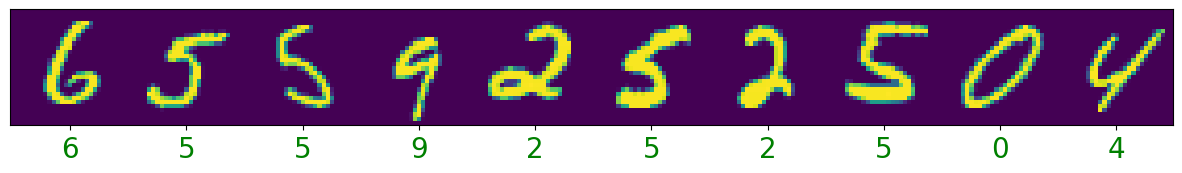

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


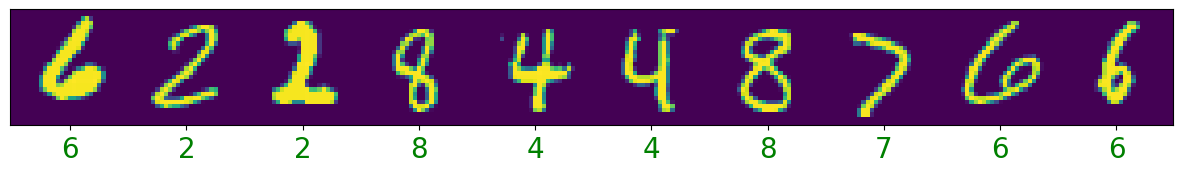

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


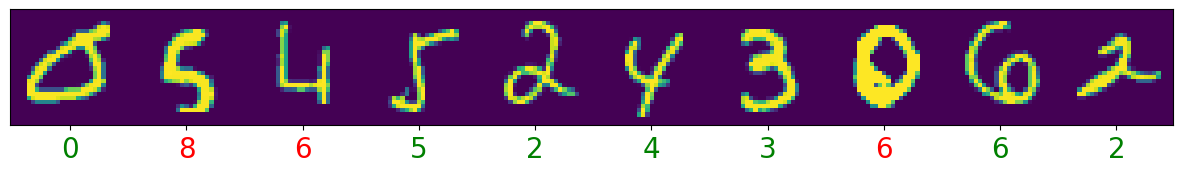

In [38]:
model = get_model()
model.fit(x_train, y_train,
          batch_size=64,
          epochs=20,
          verbose=0,
          callbacks=[VisCallback(x_test, y_test)])